<a href="https://colab.research.google.com/github/ChaseAdamson/Housing-Prices/blob/main/Housing_Prices.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Analyze and Predict Housing Prices**

The following notebook explores the housing data in the california housing data set and trains a linear regression model, a random forest model, and a quantile regression model to predict the median housing values of neighborhoods in the data set using the features of the neighborhoods. A confidence interval is also created using the quantile regression model so that the risk of the model can be assessed.


# **Import Libraries and California Housing Data**

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split # Used for splitting data
from sklearn.linear_model import LinearRegression # Used for training model 1
from sklearn.ensemble import RandomForestRegressor # Used for training model 2
!pip install lightgbm
import lightgbm as lgb # used for training model 3
from sklearn.metrics import mean_squared_error, r2_score # Used for testing models
import numpy as np
import matplotlib.pyplot as plt # Used for visualizing data
from sklearn.datasets import fetch_california_housing

# Load dataset
data = fetch_california_housing(as_frame=True)

# Convert to pandas DataFrame
df = data.frame

# Show the first few rows
df.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


# **Split Data Into Testing and Training Data**

The data is divided into a set for training/fitting the models and a set for testing the models. The reason for this is the models may simply "remember" the data instead of predicting the patterns involved if the same dataset is used for training and testing. The data is randomly divided into 80% training, and 20% testing data.

In [2]:
# Separate features (X) and target variable (y)
X = df.drop("MedHouseVal", axis=1)
y = df["MedHouseVal"]

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,       # 20% for testing, leaves 80% for training
    random_state=42      # seed ensures reproducible random split
)

X_train.shape, X_test.shape

((16512, 8), (4128, 8))

# **Create and train models**
The models are created and fitted with the data. The confidence interval is created by training two other lgb models to predict to the bottom 10th percentile and 90th percentile. The interval between these values is expected to contain the correct median house value with 80% certainty.

In [3]:
# Create and train(fit) the linear regression model
model_linear = LinearRegression()
model_linear.fit(X_train, y_train)

# Create and train the random forest model
model_forest = RandomForestRegressor()
model_forest.fit(X_train, y_train)

# Create and train quantile forest regression model for confidence intervals
model_lgb = lgb.LGBMRegressor(
    objective="quantile",
    alpha=0.5,
    n_estimators=500
)
model_lgb.fit(X_train, y_train)

# Train lower bound model
model_lgb_lower = lgb.LGBMRegressor(
    objective="quantile",
    alpha=0.1,
    n_estimators=500
)
model_lgb_lower.fit(X_train, y_train)

# Train upper bound model
model_lgb_upper = lgb.LGBMRegressor(
    objective="quantile",
    alpha=0.9,
    n_estimators=500
)
model_lgb_upper.fit(X_train, y_train)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001579 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1838
[LightGBM] [Info] Number of data points in the train set: 16512, number of used features: 8
[LightGBM] [Info] Start training from score 1.798500
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001304 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1838
[LightGBM] [Info] Number of data points in the train set: 16512, number of used features: 8
[LightGBM] [Info] Start training from score 0.825000
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002162 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1838
[LightGBM] [Info] Number of data points in the train set: 16512, number of used features: 8
[LightGBM] [Info] Start traini

LGBMRegressor(alpha=0.9, n_estimators=500, objective='quantile')

# **Test Models**

The models are used to predict the median house values of the testing data set. The accuracy of these models' predictions are tested using the rmse and R^2 values. If the confidence intervals are correct, then the upper and lower bound predictions should contain the true median house value 80% of the time. The calibration rate is measured and tested against this value.

In [4]:
# Make predictions with the linear regression model
y_pred_linear = model_linear.predict(X_test)

# Make predictions with the random forest model
y_pred_forest = model_forest.predict(X_test)

# Make predictions with the lgb model
y_pred_lgb = model_lgb.predict(X_test)

# Make confidence interval
y_pred_lgb_lower = model_lgb_lower.predict(X_test)
y_pred_lgb_upper = model_lgb_upper.predict(X_test)

# Test predictions against real data using RMSE and R^2
rmse_linear = np.sqrt(mean_squared_error(y_test, y_pred_linear))
r2_linear = r2_score(y_test, y_pred_linear)
print(f'linear rmse = {rmse_linear}, linear R^2 = {r2_linear}')

# Test predictions against real data using RMSE and R^2
rmse_forest = np.sqrt(mean_squared_error(y_test, y_pred_forest))
r2_forest = r2_score(y_test, y_pred_forest)
print(f'forest rmse = {rmse_forest}, forest R^2 = {r2_forest}')

# Test predictions against real data using RMSE and R^2
rmse_lgb = np.sqrt(mean_squared_error(y_test, y_pred_lgb))
r2_lgb = r2_score(y_test, y_pred_lgb)
print(f'lgb rmse = {rmse_lgb}, lgb R^2 = {r2_lgb}')

calibration_rate = ((np.array(y_test) >= np.array(y_pred_lgb_lower)) & (np.array(y_test) <= y_pred_lgb_upper)).mean()
print(f'calibration rate = {calibration_rate}') # fraction of confidence intervals that contain the true median house value

# Predicting prices for 5 random medhousevals to 80% confidence
indices = np.random.choice(len(y_test), size=5, replace=False)
print("80% confident median house values:")
for i in indices:
    low = y_pred_lgb_lower[i]
    high = y_pred_lgb_upper[i]
    mid = np.mean([low, high])
    delta = (high - low) / 2

    print(f"Predicted median house value: ${mid*100000:.0f} ± ${delta*100000:.0f}")

mean_confidence_interval_radius = int(100000*np.mean(y_pred_lgb_upper - y_pred_lgb_lower)/2)# average width of confidence interval
print(f"mean confidence interval radius = ${mean_confidence_interval_radius}")

linear rmse = 0.7455813830127764, linear R^2 = 0.5757877060324508
forest rmse = 0.5035688073128235, forest R^2 = 0.8064867168119767
lgb rmse = 0.4684965189875767, lgb R^2 = 0.83250344591036
calibration rate = 0.6913759689922481
80% confident median house values:
Predicted median house value: $216233 ± $62787
Predicted median house value: $236269 ± $74399
Predicted median house value: $117479 ± $26042
Predicted median house value: $128764 ± $23562
Predicted median house value: $148965 ± $35914
mean confidence interval radius = $39587


# **Interpreting Results**

* **Linear Regression Model:** Based on the rmse, the linear regression model estimated the true values with an RMSE of about \$75,000 because the units are scaled down in the dataset by a factor of 100,000. This means the mean absolute error of predictions is a little less than \$75,000 for this dataset which is not dominated by extremely erronious predictions. The value of R^2 indicates the proportion of the median house value that the model accounts for which is about 0.58 or 58%. This is a somewhat useful model for predicting median house values as long as the risk of a prediction is low.

* **Random Forest Model:** The forest model estimated median house values with an RMSE of about \$51,000. Again this means the mean absolute error is slightly under \$51,000. Based on the R^2 value, the model accounts for 81% of the median house value. This is a significant improvement in both metrics from the linear regression model.

* **Quantile Regression Model:** The LGB model estimated median house values with an RMSE of about \$47,000. This means the mean absolute error is slightly under \$47,000. Based on the R^2 value, the model accounts for 83% of the median house value. This is the best model for predicting the median house values by both metrics.

The confidence interval which was supposed to be 80% reliable was tested and found to be 69% reliable in the test data according to the calibration rate. This means while we would have expected the true median house value to fall within the confidence interval 80% of the time, it only fell into the confidence interval 69% of the time. This means the confidence intervals are slightly too small on average.

# **Visualizing Data**

Below are six plots which offer visualizations of the data gathered. The predictions of the models are placed on scatter plots against the true median house values for the first three plots. For the next two, the confidence intervals are visualized on scatter plots. One is a scatter plot with the upper bound predictions, lower bound predictions, and actual predictions plotted together in different colors. The final scatter plot is the predictions of the lgb model with error bars to indicate the size of the confidence intervals. The final plot is a histogram with the confidence interval radii on the x-axis and the frequency on the y-axis.

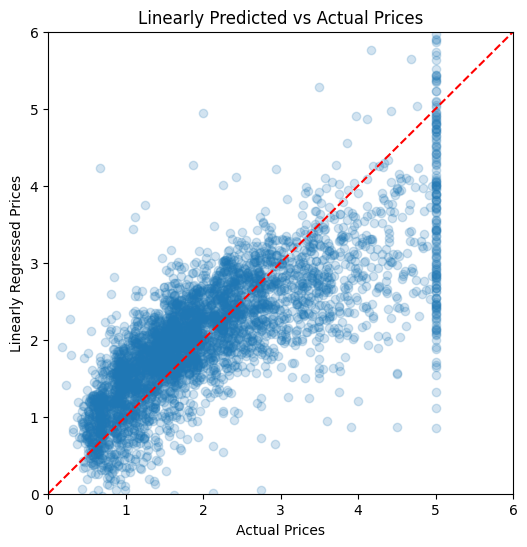

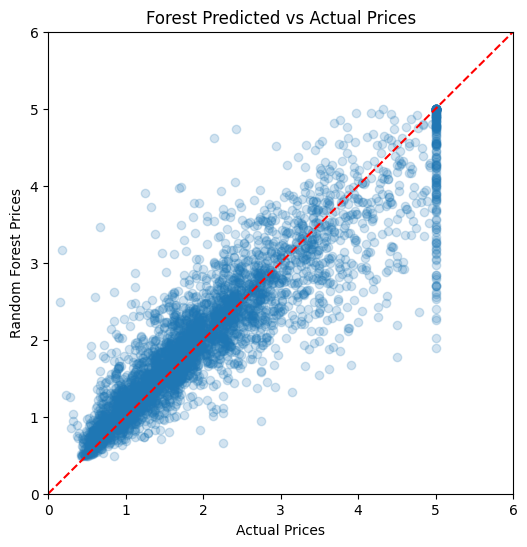

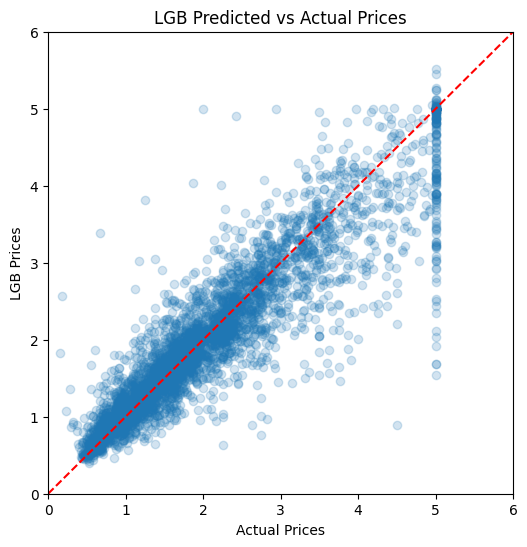

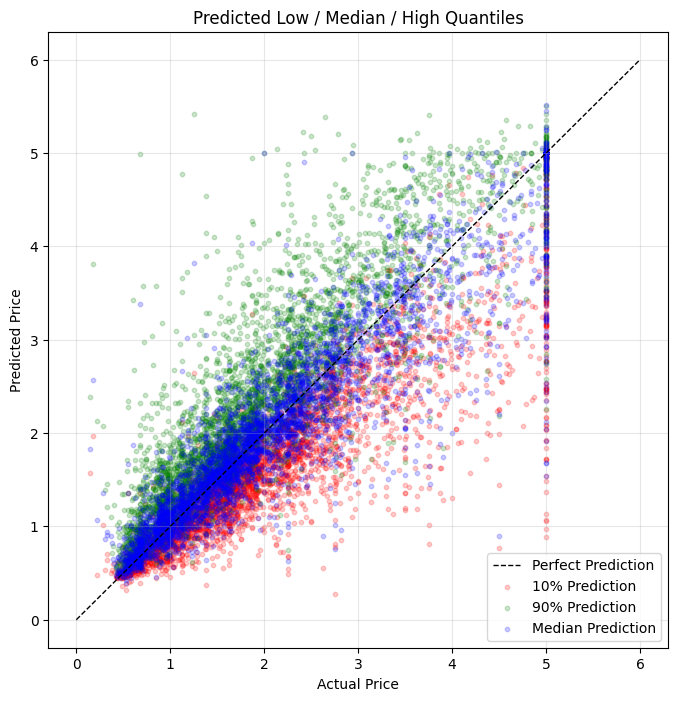

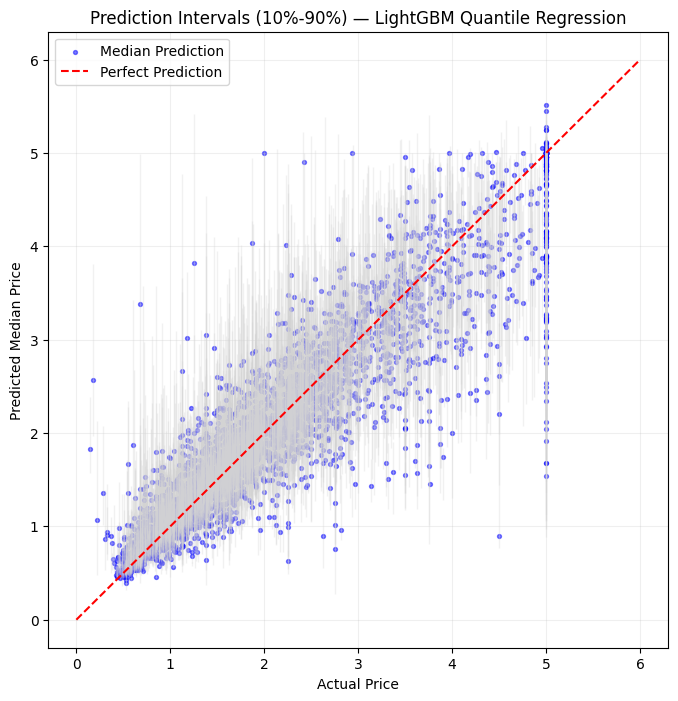

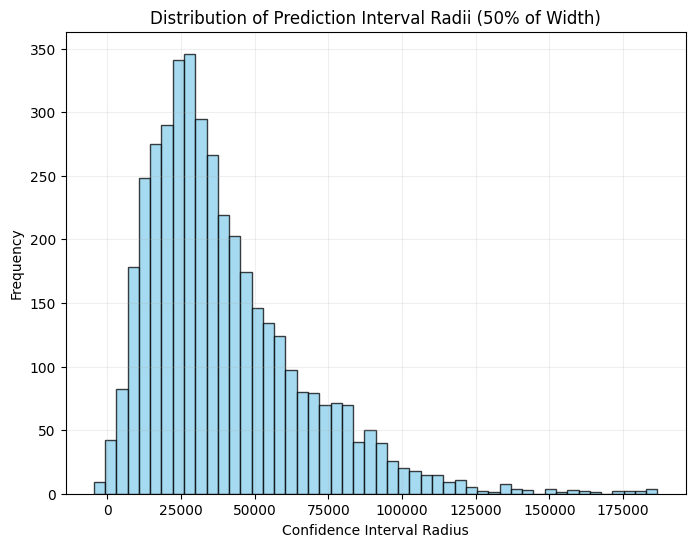

In [7]:
# Set reasonable limit values
min = 0
max = 6

########## Plot linear regression prices ##########

plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred_linear, alpha=0.2)
plt.xlim(min, max)
plt.ylim(min, max)
plt.xlabel("Actual Prices")
plt.ylabel("Linearly Regressed Prices")
plt.title("Linearly Predicted vs Actual Prices")
plt.xlim()
plt.plot([min, max],
         [min, max],
         'r--')  # perfect predictions line
plt.show()

########## Plot random forest prices ##########

plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred_forest, alpha=0.2)
plt.xlim(min, max)
plt.ylim(min, max)
plt.xlabel("Actual Prices")
plt.ylabel("Random Forest Prices")
plt.title("Forest Predicted vs Actual Prices")
plt.plot([min, max],
         [min, max],
         'r--')  # perfect predictions line
plt.show()

########## Plot lgb prices ##########

plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred_lgb, alpha=0.2)
plt.xlim(min, max)
plt.ylim(min, max)
plt.xlabel("Actual Prices")
plt.ylabel("LGB Prices")
plt.title("LGB Predicted vs Actual Prices")
plt.plot([min, max],
         [min, max],
         'r--')  # perfect predictions line
plt.show()

########## plot low and high confidence interval predictions ##########

actual = np.array(y_test)
plt.figure(figsize=(8, 8))
min_val = 0
max_val = 5
plt.plot([min, max], [min, max], "k--", linewidth=1, label="Perfect Prediction")

# Plot the low, median, and high predictions with different colors
plt.scatter(actual, y_pred_lgb_lower,  s=10, alpha=0.2, color="red",   label="10% Prediction")
plt.scatter(actual, y_pred_lgb_upper, s=10, alpha=0.2, color="green", label="90% Prediction")
plt.scatter(actual, y_pred_lgb,  s=10, alpha=0.2, color="blue",  label="Median Prediction")

plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Predicted Low / Median / High Quantiles")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

########## Create confidence interval scatter plot ##########

# Sort by actual values so intervals display cleanly
order = np.argsort(y_test)
actual_sorted = np.array(y_test)[order]
low_sorted = np.array(y_pred_lgb_lower)[order]
med_sorted = np.array(y_pred_lgb)[order]
high_sorted = np.array(y_pred_lgb_upper)[order]

plt.figure(figsize=(8, 8))

# Light, thin interval bars
plt.vlines(
    actual_sorted,
    low_sorted,
    high_sorted,
    color="lightgray",
    alpha=0.3,
    linewidth=1
)

# Median predictions
plt.scatter(
    actual_sorted,
    med_sorted,
    s=8,
    alpha=0.5,
    color="blue",
    label="Median Prediction"
)

# Perfect prediction line
plt.plot([min, max], [min, max], "r--", label="Perfect Prediction")

plt.xlabel("Actual Price")
plt.ylabel("Predicted Median Price")
plt.title("Prediction Intervals (10%-90%) — LightGBM Quantile Regression")
plt.legend()
plt.grid(alpha=0.2)
plt.show()

########## Histogram for confidence intervals ##########
interval_width = 100000*(y_pred_lgb_upper - y_pred_lgb_lower)
interval_radius = interval_width / 2.0

plt.figure(figsize=(8, 6))
plt.hist(interval_radius, bins=50, color="skyblue", edgecolor="black", alpha=0.75)
plt.xlabel("Confidence Interval Radius")
plt.ylabel("Frequency")
plt.title("Distribution of Prediction Interval Radii (50% of Width)")
plt.grid(alpha=0.2)
plt.show()


# **Final Analysis**

* **Linear Regression Model:** The model looks like it slightly over-predicted for homes cheaper than \$150,000 and under-predicted for home more expensive than \$250,000. The vertical line at \$500,000 is caused because there are lots of data entries for which the medhouseval is exactly \$500,000, so the scatter plot forms a vertical line representing the spread of the predictions for those entries. The line is long which indicates the model does a poor job at predicting the price of homes at \$500,000 in this dataset.

* **Random Forest Model:** The model does a much better job for all values. The data is much closer to the line representing perfect predictions and the vertical line is much more sparse far away from this line.

* **LGB Quantile Regression Model:** The model looks like it made predictions similarly to the forest model which the metrics indicate is true. The vertical line is also sparse far away from the perfect prediction line.

* **Confidence Intervals:** The final visualizations show that most prediction intervals are quite narrow, meaning the model is confident for the majority of homes. In the triple scatter plot, the red (10th percentile) and green (90th percentile) points lie very close to the blue median predictions, forming a tight cluster. This indicates that for most samples, the predicted uncertainty is small. The error-bar scatter plot reinforces this: the gray vertical intervals overlap heavily and appear darker in a narrow band, meaning many intervals are small and stacked on top of each other. Only a minority of samples exhibit very large confidence intervals, which show up clearly as long vertical lines. These represent cases where the model is uncertain, typically corresponding to unusual or harder-to-predict homes. Overall, the model provides tight, reliable intervals for most predictions, with a small number of high-uncertainty outliers. The histogram confirms this by showing the interval radius distribution has a peak at around \$30,000 and a long tail extending past \$150,000.

The models can be clearly ranked by their utility in order of linear regression, random forest regression, and quantile regression, with linear regression being the worst and quantile regression being the best. The confidence intervals made possible with quantile regression are also useful in assessing risk, though they should be calibrated to be a little larger in order to reliably make predictions with the confidence expected of them.